In [1]:
%%capture
!pip install squarify
%%hide output

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Liberation Sans", "DejaVu Sans", "Helvetica"],
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "font.weight": "regular"
})
sns.set_theme(style="whitegrid", rc=plt.rcParams)


## Importing libraries

To change directory from google colab into google drive, must connect to gdrive first (accept all conditions)


In [2]:
import os
import pandas as pd
import zipfile
import numpy as np
import squarify
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

sns.set_theme(style="whitegrid", rc={
    "axes.facecolor": "white",
    "grid.color": "#f2f2f2",
    "axes.edgecolor": "none"
})

# changes directory from colab to gdrive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

The purpose of our EDA is to find insights that will help us later to how clean our data and ultimately create our models.


**Note**:

1. This is the EDA for baseline MRI data, which is our data of focus in the first
experiment. In the first experiment, we plan to do a cross-sectional prediction, namely predicting whether the patient has Alzheimer or not. We will take care of the temporal effect in the second experiment.

2. This is the EDA for meta data/data dictionary only.


## I. Creating data paths

In [4]:
base_path = os.path.join('/content', 'drive', 'MyDrive', 'Capstone-Project')
os.chdir(base_path)
baseline_path = 'data/adni1-data/baseline/'
baseline_csv = 'ADNI1_Baseline_3T_2_25_2023.csv'  # data dictionary

## II. Observe metadata

In [5]:
data = os.path.join(base_path, baseline_path, baseline_csv)
df = pd.read_csv(data, parse_dates=['Acq Date'])
df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I122678,031_S_0568,MCI,F,80,bl,MRI,MPR; GradWarp; N3; Scaled,Processed,2006-06-09,NiFTI,2/15/2023
1,I118854,023_S_0061,CN,F,77,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2005-12-20,NiFTI,2/15/2023
2,I119018,023_S_0331,MCI,F,65,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2006-04-12,NiFTI,2/15/2023
3,I118920,023_S_1190,CN,F,77,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2007-01-17,NiFTI,2/15/2023
4,I118862,023_S_0078,MCI,F,76,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2006-01-12,NiFTI,2/15/2023


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Image Data ID  199 non-null    object        
 1   Subject        199 non-null    object        
 2   Group          199 non-null    object        
 3   Sex            199 non-null    object        
 4   Age            199 non-null    int64         
 5   Visit          199 non-null    object        
 6   Modality       199 non-null    object        
 7   Description    199 non-null    object        
 8   Type           199 non-null    object        
 9   Acq Date       199 non-null    datetime64[ns]
 10  Format         199 non-null    object        
 11  Downloaded     199 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 18.8+ KB


Here we can see that there are no null values. Most are of type object. We can also see that there are unnecessary variables like Format, Downloaded, Modality, Visit. We can plan to remove those later

## III. Drop unused columns & Split up date into year, month, day columns

In [7]:
df = df.drop(['Visit', 'Modality', 'Type', 'Format', 'Downloaded'], axis=1, errors = 'ignore')

df['Acq_year'] = pd.DatetimeIndex(df['Acq Date']).year
df['Acq_month'] = pd.DatetimeIndex(df['Acq Date']).month
df['Acq_day'] = pd.DatetimeIndex(df['Acq Date']).day
df = df.drop(['Acq Date'], axis=1, errors = 'ignore')
df.head()

,Image Data ID,Subject,Group,Sex,Age,Description,Acq_year,Acq_month,Acq_day
0,I122678,031_S_0568,MCI,F,80,MPR; GradWarp; N3; Scaled,2006,6,9
1,I118854,023_S_0061,CN,F,77,MPR; GradWarp; B1 Correction; N3; Scaled_2,2005,12,20
2,I119018,023_S_0331,MCI,F,65,MPR; GradWarp; B1 Correction; N3; Scaled_2,2006,4,12
3,I118920,023_S_1190,CN,F,77,MPR; GradWarp; B1 Correction; N3; Scaled_2,2007,1,17
4,I118862,023_S_0078,MCI,F,76,MPR; GradWarp; B1 Correction; N3; Scaled_2,2006,1,12


In [8]:
df = df.rename({'Image Data ID': 'Img_ID', 'Description':"Desc"}, axis=1)
df.head()

,Img_ID,Subject,Group,Sex,Age,Desc,Acq_year,Acq_month,Acq_day
0,I122678,031_S_0568,MCI,F,80,MPR; GradWarp; N3; Scaled,2006,6,9
1,I118854,023_S_0061,CN,F,77,MPR; GradWarp; B1 Correction; N3; Scaled_2,2005,12,20
2,I119018,023_S_0331,MCI,F,65,MPR; GradWarp; B1 Correction; N3; Scaled_2,2006,4,12
3,I118920,023_S_1190,CN,F,77,MPR; GradWarp; B1 Correction; N3; Scaled_2,2007,1,17
4,I118862,023_S_0078,MCI,F,76,MPR; GradWarp; B1 Correction; N3; Scaled_2,2006,1,12


## IV. Split 'Desc' (description) column into binary

In [12]:
# Step 1: Clean the 'Desc' column (replace specific patterns)
desc_cleaned = (
    df['Desc']
    .fillna('')
    .str.replace(r'\(?Scaled_2\)?', 'Scaled', regex=True)
)

# Step 2: Split by delimiter, expand, and stack to long format
desc_split = desc_cleaned.str.split("; ")
desc_stacked = desc_split.apply(pd.Series).stack().reset_index(level=1, drop=True)

# Step 3: One-hot encode the stacked values
desc_dummies = pd.get_dummies(desc_stacked)

# Step 4: Group back by original index (row-wise one-hot encoded features)
desc_encoded = desc_dummies.groupby(level=0).sum()

# Step 5: Optional column rename
desc_encoded.rename(columns={'B1 Correction': 'B1'}, inplace=True)

# Step 6: Combine with original DataFrame (excluding 'Desc' column)
dfc = pd.concat([df.drop(columns='Desc'), desc_encoded], axis=1)

# Step 7: View or return final result
print(dfc.head())


    Img_ID     Subject Group Sex  Age  Acq_year  Acq_month  Acq_day     B1  \
0  I122678  031_S_0568   MCI   F   80      2006          6        9  0   0   
1  I118854  023_S_0061    CN   F   77      2005         12       20  0   1   
2  I119018  023_S_0331   MCI   F   65      2006          4       12  0   1   
3  I118920  023_S_1190    CN   F   77      2007          1       17  0   1   
4  I118862  023_S_0078   MCI   F   76      2006          1       12  0   1   

   GradWarp  MPR  MPR-R  N3  Scaled  
0         1    1      0   1       1  
1         1    1      0   1       1  
2         1    1      0   1       1  
3         1    1      0   1       1  
4         1    1      0   1       1  


In [13]:
dfc=dfc.loc[dfc.Scaled==1]

# Preprocessing Pipeline description

MRI images from the ADNI dataset, we think, come partially preprocessed.

ADNI Pipeline uses is a preprocessing pipeline used to perform a series of steps to convert the raw image into a preprocessed image.

These steps can include N3/N4 bias correction, skull stripping, registration, intensity normalization, scaling and spatial normalization.

Preprocessing Definitions:
  > **N3**: Correct for intensity non-uniformity in the image, which can be caused by a variety of factors including differences in coil sensitivity, magnetic field inhomogeneities, and tissue properties.

  > **N4**: Corrects for intensity non-uniformity in the MRI data caused by variations in the magnetic field and other factors

  > **Gradwarp**: Corrects for intensity variations in the magnetic field of the scnaner, which can cause distortions in the image. These distortions can cause errors in subsequent image processing steps

  > **Distortion correction**: Used to correct for spatial distortions in the image that are caused by factors such as gradient nonlinearities, susceptibility artifacts, and motion.

  > **B1 Correction**: is a type of correction for radiofrequency (RF) inhomogeneity in MRI images. RF inhomogeneity occurs when the RF field is not perfectly uniform across the image.

  > **Skull Stripping**: Removes non-brain tissue from the MRI images

  > **Registration**: Aligns the MRI images to a standard space, such as the MNI (Montreal Neurological Institute) template

  > **Spatial Normalizaiton**: Warps the images to fit the template space, correcting for differences in brain size and shape between individuals
  
  > **Intensity Normalization**: Rescales the intensity values of the images to a common range.

  > **Scaled**: Not too sure what this is. On the documentation they have parameters scaled(1.00002, 1, 1.0003) or something similar.

  > **Motion correction**: Motion correction is typically performed to correct for subject motion during the acquisition of the images. These artifacts can cause blurring or ghosting in the image, which can affect subsequent image processing steps.

  > **Smoothing**: Spatial smoothing is performed to improve the signal-to-noise ratio of the images and to reduce noise and other unwanted variability.

The assumption is they become preprocessed, because the images are not intensity normalized or skull stripped.

We know for sure that they are N3 bias corrected, Gradwarped, scaled. They're also registered.

**MPR and MPR_R**:
In ADNI preprocessing, MPR and MPR-R refer to two different acquisitions of the same imaging modality, specifically the magnetization-prepared rapid gradient echo (MPRAGE) sequence. MPR refers to the first acquisition of the MPRAGE sequence, while MPR-R refers to a repeat acquisition that is obtained immediately after the first acquisition.

The purpose of acquiring two MPRAGE scans in quick succession is to improve the quality of the image by reducing the effects of noise, motion artifacts, and other sources of variability. The two scans are then averaged or combined in some way to produce a single high-quality image.


## V. Check NA

In [15]:
def count_nulls(df):
    null_counter = df.isnull().sum(axis=0)
    null_counter = null_counter[null_counter > 0]
    null_percent = df.isnull().sum(axis=0) / df.shape[0] * 100
    null_percent = null_percent[null_percent > 0]
    null_df = pd.concat([null_counter,null_percent],axis=1)
    null_df.columns = ['count','percent']
    display(null_df)

count_nulls(dfc)

,count,percent


## VI. Subject-level EDA

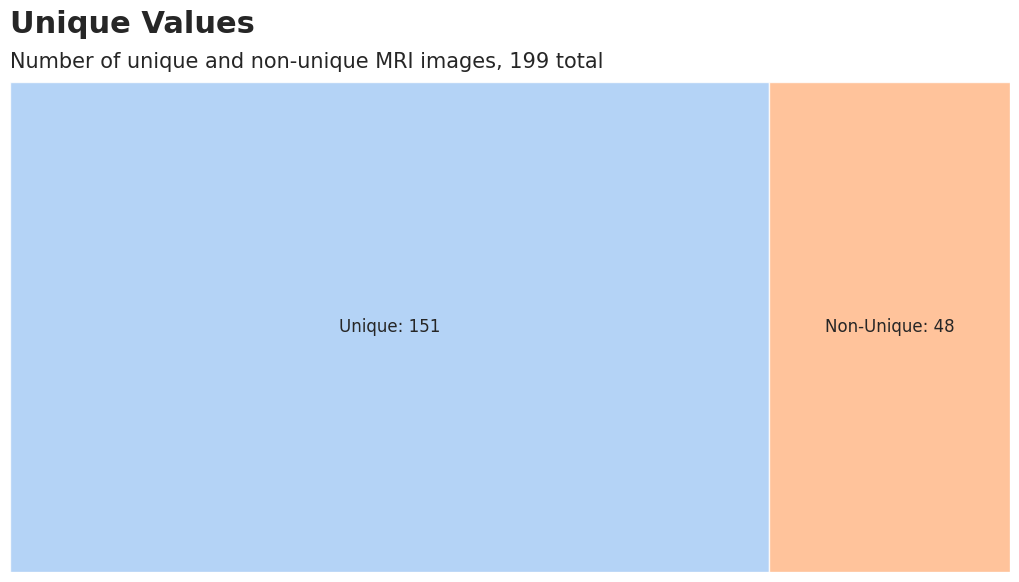

In [40]:
unique_vals = len(dfc.Subject.unique())
n = dfc.shape[0]


############# PLOT
color = sns.color_palette("pastel")
fig, ax = plt.subplots(figsize=(10, 7))
squarify.plot(sizes=[unique_vals, n-unique_vals], label=[f'Unique: {unique_vals}', f'Non-Unique: {n-unique_vals}'], alpha=.8, color=color)
ax.axis('off')

# remove padding left and right, add some to top and bot
fig.subplots_adjust(left=0, right=1, top=0.8, bottom=0.1)

# Add title
fig.text(
    0, 0.87, "Unique Values",
    fontsize=22, fontweight="bold"
)

# Add subtitle
fig.text(
    0, 0.82, "Number of unique and non-unique MRI images, 199 total",
    fontsize=15
)
plt.show()


31.78% of the data is not unique. This means that some of our data will be of the exact same person. A person could have 5 MRI scans of them taken, or 2. Having the same photo taken of a person but 5 days apart, could be useless and make cause bias in the model. We might have to remove them later or find a new dataset

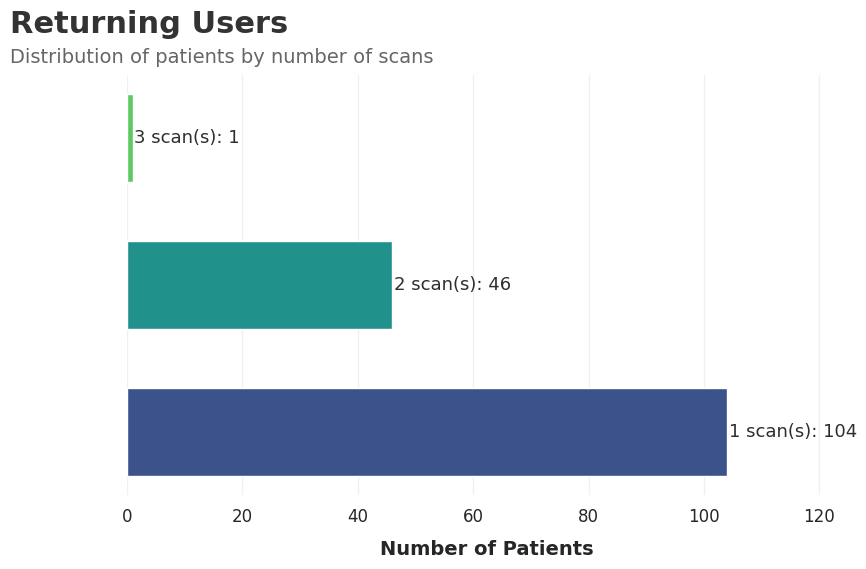

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data prep
duplicates = dfc.groupby(['Subject']).size().value_counts()
names = list(map(str, duplicates.index))
counts = duplicates.values

# Style setup
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "#f0f0f0"})

# Plot
fig, ax = plt.subplots(figsize=(9, 6))
bars = ax.barh(
    names, counts, height=0.6,
    color=sns.color_palette("viridis", len(names))
)

# Clean up spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(axis="y", visible=False)

# Adjust padding
fig.subplots_adjust(left=0.15, right=0.95, top=0.85, bottom=0.15)

# Labels and title
ax.set_xlabel("Number of Patients", fontsize=14, labelpad=10, fontweight="bold")
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=12)
ax.set_yticklabels([])

# Add title & subtitle
fig.text(0.02, 0.92, "Returning Users", fontsize=22, fontweight="bold", color="#333333")
fig.text(0.02, 0.87, "Distribution of patients by number of scans", fontsize=14, color="#666666")

# Annotate bars
for name, count, bar in zip(names, counts, bars):
    ax.text(
        bar.get_width() + 0.3, bar.get_y() + bar.get_height() / 2,
        f"{name} scan(s): {count}",
        va="center", fontsize=13, color="#2e2e2e"
    )

# Light aesthetic tweaks
ax.set_xlim(0, max(counts) * 1.2)
sns.despine(left=True, bottom=True)

plt.show()


/tmp/ipython-input-1512621502.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(names, fontsize=14, color="#333333")


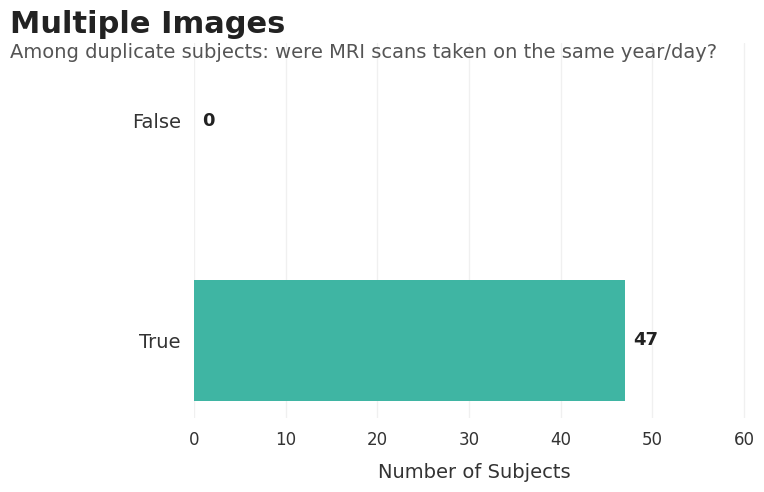

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ===============================
# Step 1–4: Prepare data
# ===============================
dup_rows = dfc[dfc['Subject'].duplicated(keep=False)][[
    'Img_ID', 'Subject', 'Acq_year', 'Acq_month', 'Acq_day', 'MPR', 'MPR-R'
]]

dup_row_gb_yrd = dup_rows.groupby(['Subject', 'Acq_year', 'Acq_day']).size()
has_multiple = (dup_row_gb_yrd > 1).values
unique_vals, counts = np.unique(has_multiple, return_counts=True)

names = ['True', 'False']
counts_dict = dict(zip(unique_vals.astype(str), counts))
counts = [counts_dict.get('True', 0), counts_dict.get('False', 0)]

# ===============================
# Step 5: Beautiful Plot
# ===============================
sns.set(style="whitegrid", rc={
    "axes.facecolor": "white",
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "none"
})

fig, ax = plt.subplots(figsize=(8, 5))

# Color palette: green for True, gray for False
palette = {"True": "#3FB5A3", "False": "#B0BEC5"}
bars = ax.barh(names, counts, height=0.55,
               color=[palette[n] for n in names], edgecolor="none")

# Title and subtitle
fig.text(0.02, 0.92, "Multiple Images", fontsize=22, fontweight="bold", color="#222222")
fig.text(
    0.02, 0.87,
    "Among duplicate subjects: were MRI scans taken on the same year/day?",
    fontsize=14, color="#555555"
)

# X-axis
ax.set_xlabel("Number of Subjects", fontsize=14, labelpad=10, color="#333333")
ax.tick_params(axis='x', labelsize=12, colors="#333333")
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Clean y-axis
ax.set_yticklabels(names, fontsize=14, color="#333333")
ax.grid(axis='y', visible=False)

# Add count labels
for bar, name, count in zip(bars, names, counts):
    ax.text(
        count + max(counts)*0.02,                # position label slightly outside bar
        bar.get_y() + bar.get_height() / 2,
        f"{count:,}",                            # formatted with commas
        va="center", ha="left",
        fontsize=13, color="#222222", fontweight="semibold"
    )

# Adjust layout
ax.set_xlim(0, max(counts) * 1.3)
fig.subplots_adjust(left=0.25, right=0.95, top=0.9, bottom=0.15)
sns.despine(left=True, bottom=True)

plt.show()


Every single duplicate subject had two (three for one individual) images taken on the same day. This could be due to MPR/MPR-R acquisitions where researchers take multiple MRI scans in order to improve the quality of the image. They take the average of the two images in hopes to reduce the noise and motion effects.

This is something we will have to deal with later. We can remove the datapoints or we can do the MPR/MPR-R preprocessing talked about in the previous paragraph.

## VII. Age-level EDA

/tmp/ipython-input-2298894752.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=ser, hist=True, kde=True, rug=False, bins=bins,
/usr/local/lib/python3.12/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


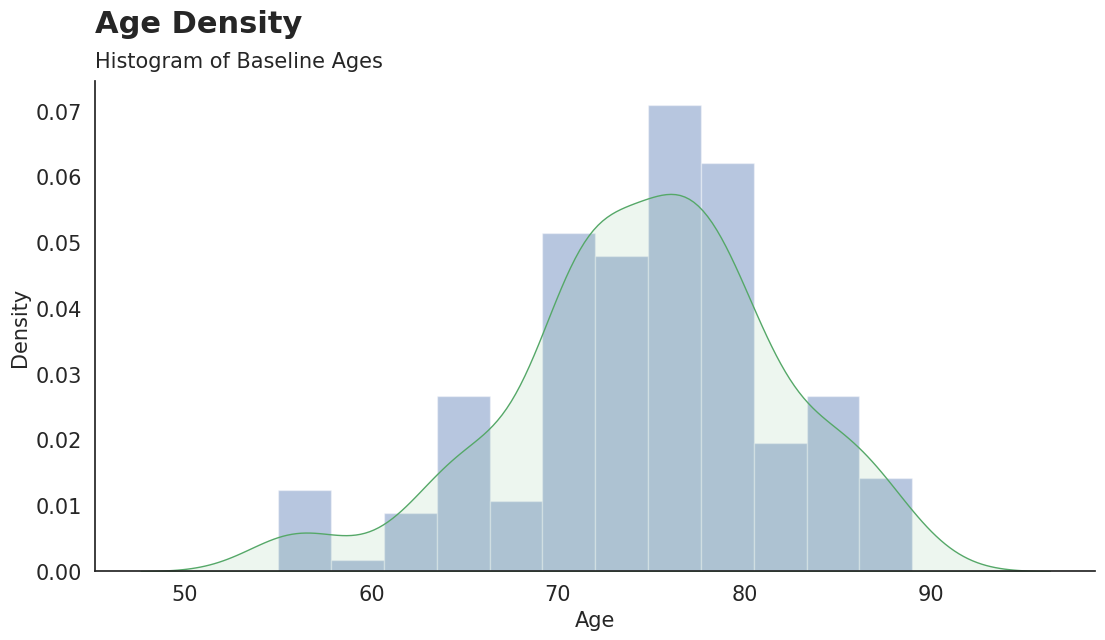

/tmp/ipython-input-2298894752.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=ser, hist=True, kde=True, rug=False, bins=bins,
/usr/local/lib/python3.12/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


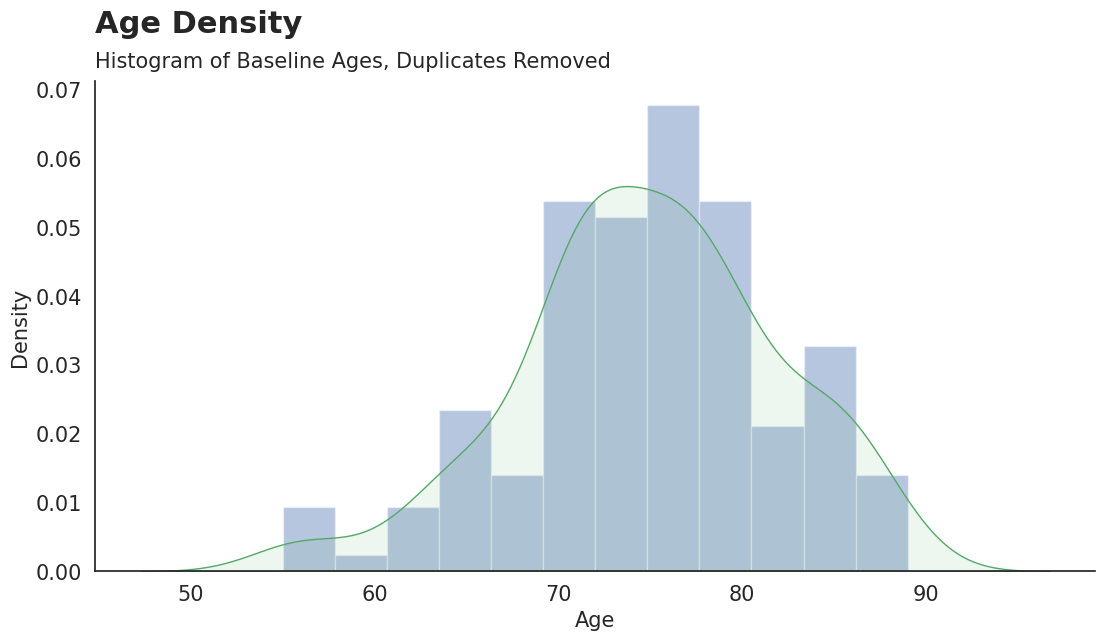

In [ ]:
# df dupes removed
dfdr = dfc.drop_duplicates('Subject')

def plot_hist(ser, bins, sub_title='Histogram of Baseline Ages'):
  ############# PLOT
  fig, ax = plt.subplots(figsize=(10, 7))
  sns.distplot(a=ser, hist=True, kde=True, rug=False, bins=bins,
               kde_kws={"color": "g", "alpha": 0.1, "linewidth": 1, "shade": True})
  # sns.histplot(data=dfc['Age'], kde=True, stat='density', ax=ax, bins=20)


  # remove padding left and right, add some to top and bot
  fig.subplots_adjust(left=0, right=1, top=0.8, bottom=0.1)

  ax.spines["top"].set_visible(False)
  ax.spines["right"].set_visible(False)

  # y and x ticks
  ax.tick_params(axis='both', which='major', labelsize=15)

  # y labels
  ax.set_ylabel("Density", fontsize=15)
  ax.set_xlabel("Age", fontsize=15)

  # Add title
  fig.text(
      0, 0.87, "Age Density",
      fontsize=22, fontweight="bold"
  )

  # Add subtitle
  fig.text(
      0, 0.82, sub_title,
      fontsize=15
  )

  plt.show()
  #######################

plot_hist(dfc['Age'], 12)
plot_hist(dfdr['Age'], 12, "Histogram of Baseline Ages, Duplicates Removed")

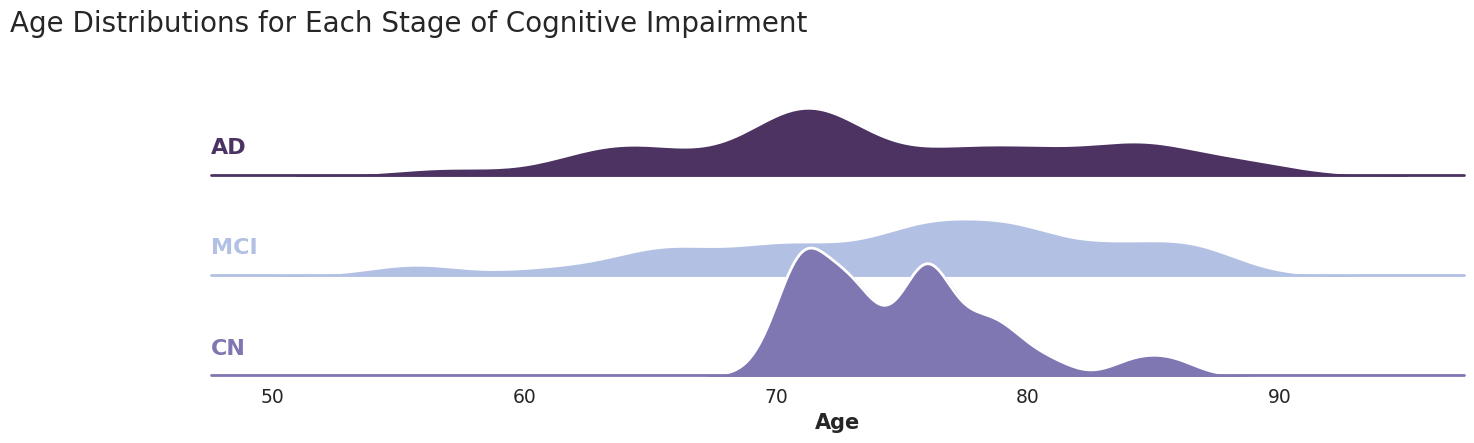

In [23]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(n_colors=3, start=0.4, rot=-.25, light=.75, dark=0.25)
g = sns.FacetGrid(dfdr, row="Group", hue="Group", aspect=9, height=1.5, palette=pal, row_order=['AD', 'MCI', 'CN'])

# Draw the densities in a few steps
g.map(sns.kdeplot, "Age",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Age", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", fontsize=16, transform=ax.transAxes)
    plt.xlabel('Age', fontweight='bold', fontsize=15)
    plt.setp(ax.get_xticklabels(), fontsize=13.5)

g.map(label, "Age")

# subtitle
g.fig.suptitle('Age Distributions for Each Stage of Cognitive Impairment',
               ha='right',
               fontsize=20,
               fontweight=20)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

Age group is roughly normal with and without the duplicates.

## VIII. Alzheimers Group (Cognitively Normal, Mild Cognitive Impairment, Alzheimers Disease), Sex, Year EDA

In [ ]:
# ----------------------------
# Helpers
# ----------------------------
def add_bar_labels(ax, fmt="{:,.0f}", offset=0.01):
    """Add value labels to bars for vertical or horizontal bar plots."""
    for p in ax.patches:
        if p.get_width() > p.get_height():  # horizontal bars
            x = p.get_x() + p.get_width() + offset * ax.get_xlim()[1]
            y = p.get_y() + p.get_height() / 2
            ax.text(x, y, fmt.format(p.get_width()), va="center", ha="left", fontsize=11, color="#333333")
        else:  # vertical bars
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + p.get_height()
            ax.text(x, y + offset * ax.get_ylim()[1], fmt.format(p.get_height()), va="bottom", ha="center", fontsize=11, color="#333333")

def nice_ax(ax, xlabel=None, ylabel=None, title=None, rotate_x=0):
    for spine in ["top", "right", "left"]:
        ax.spines[spine].set_visible(False)
    ax.grid(axis="y", alpha=0.25)
    if xlabel: ax.set_xlabel(xlabel, fontsize=13)
    if ylabel: ax.set_ylabel(ylabel, fontsize=13)
    if title:  ax.set_title(title, fontsize=16, weight="bold", loc="left")
    ax.tick_params(labelsize=11)
    if rotate_x:
        for tick in ax.get_xticklabels():
            tick.set_rotation(rotate_x)
            tick.set_horizontalalignment("right")

### a. Alzheimer's Group

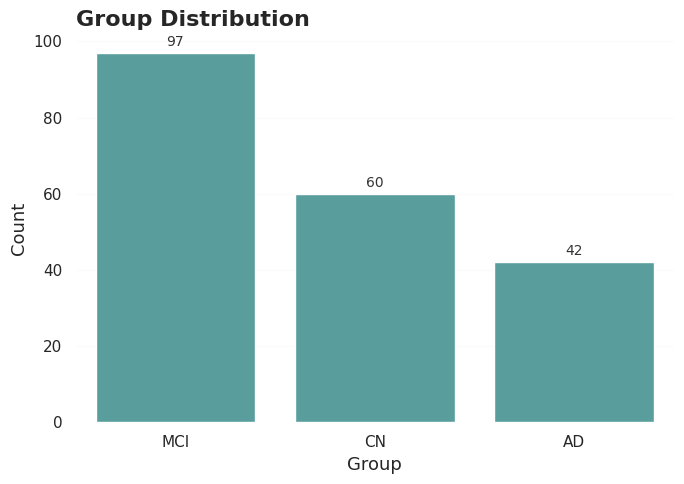

In [26]:
# ----------------------------
# 1) Counts: Group
# ----------------------------
fig, ax = plt.subplots(figsize=(7, 5))
group_counts = dfc["Group"].value_counts().sort_values(ascending=False)
sns.barplot(x=group_counts.index, y=group_counts.values, ax=ax, color="#4DA8A9", edgecolor="white")
nice_ax(ax, xlabel="Group", ylabel="Count", title="Group Distribution", rotate_x=0)
add_bar_labels(ax)
plt.tight_layout()
plt.show()


From the data, we can see that most of subjects have Mild Cognitive Impairment.

### b. Sex

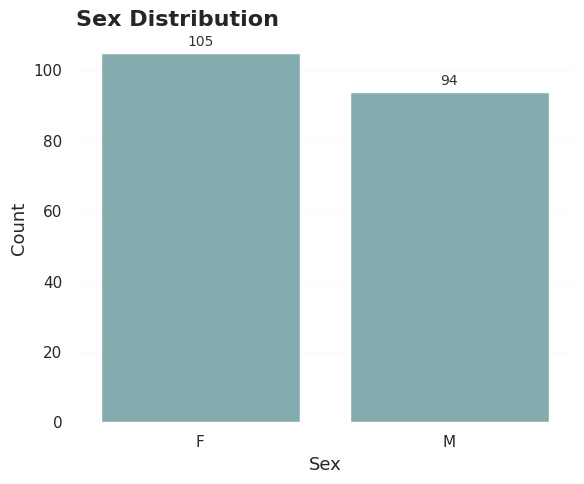

F − M count difference: 11


In [27]:
# ----------------------------
# 2) Counts: Sex
# ----------------------------
fig, ax = plt.subplots(figsize=(6, 5))
sex_counts = dfc["Sex"].value_counts().reindex(["F", "M"]).fillna(0).astype(int)
sns.barplot(x=sex_counts.index, y=sex_counts.values, ax=ax, color="#7DB3B5", edgecolor="white")
nice_ax(ax, xlabel="Sex", ylabel="Count", title="Sex Distribution")
add_bar_labels(ax)
plt.tight_layout()
plt.show()

# F–M difference
female_minus_male = int(sex_counts.get("F", 0) - sex_counts.get("M", 0))
print("F − M count difference:", female_minus_male)

#### **Observation: There are more women subjects in the data, thouogh the difference is not very big.**

### c. Group/Sex

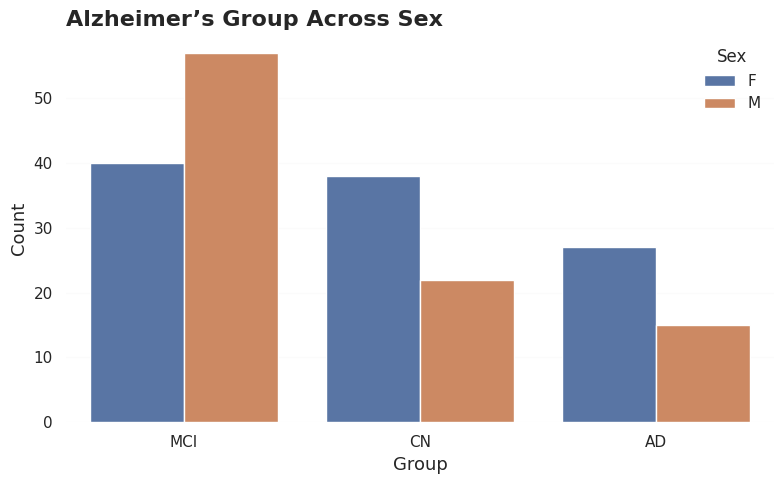

In [28]:
# ----------------------------
# 3) Group × Sex (stacked by hue)
# ----------------------------
fig, ax = plt.subplots(figsize=(8, 5))
order_groups = dfc["Group"].value_counts().index.tolist()
sns.countplot(data=dfc, x="Group", hue="Sex", order=order_groups, ax=ax)
ax.legend(title="Sex", frameon=False)
nice_ax(ax, xlabel="Group", ylabel="Count", title="Alzheimer’s Group Across Sex")
plt.tight_layout()
plt.show()

#### **Observation: Interesting, we find that actually men subjects have more Mild Cognitive Impairment.**

### d. Year

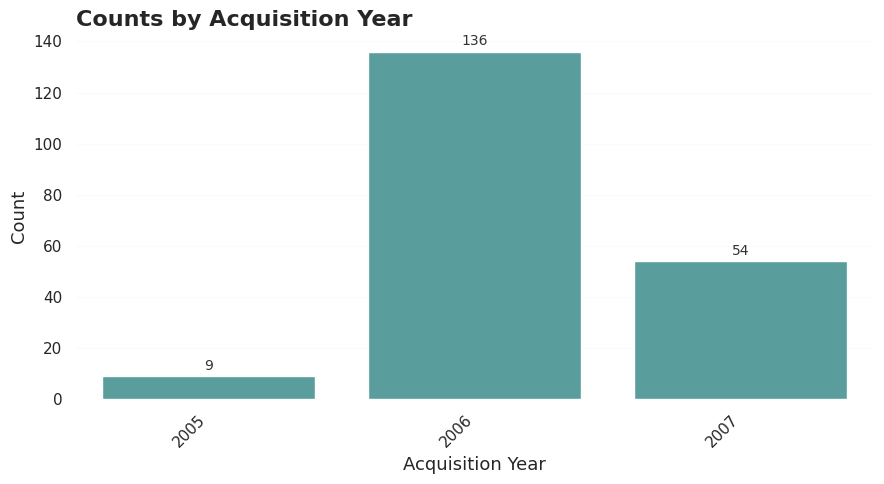

In [29]:
# ----------------------------
# 4) Acquisition Year (sorted)
# ----------------------------
fig, ax = plt.subplots(figsize=(9, 5))
year_counts = dfc["Acq_year"].value_counts().sort_index()
sns.barplot(x=year_counts.index.astype(str), y=year_counts.values, ax=ax, color="#4DA8A9", edgecolor="white")
nice_ax(ax, xlabel="Acquisition Year", ylabel="Count", title="Counts by Acquisition Year", rotate_x=45)
add_bar_labels(ax)
plt.tight_layout()
plt.show()

#### **Observation: Most frequent acquisition date is 2006.**

### e. Correlation Matrix

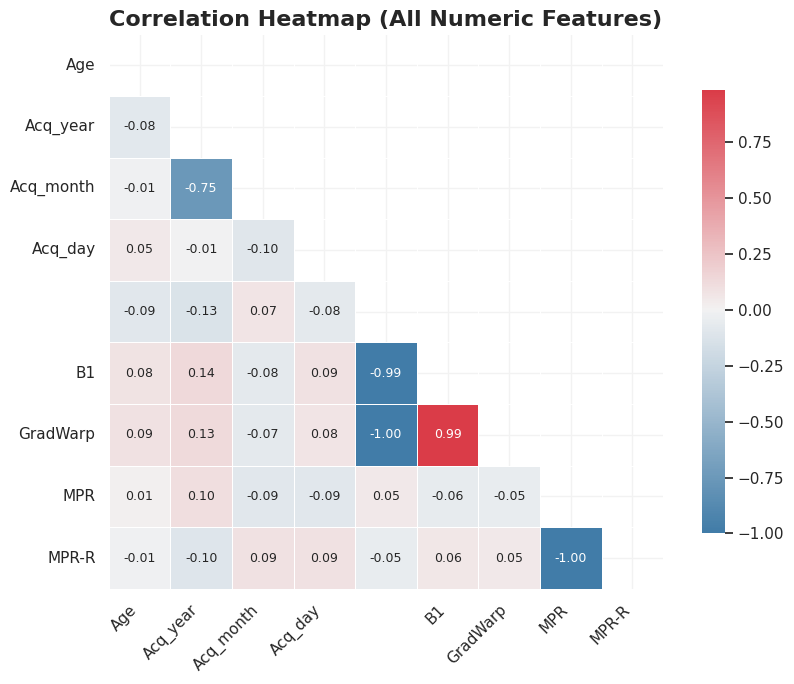

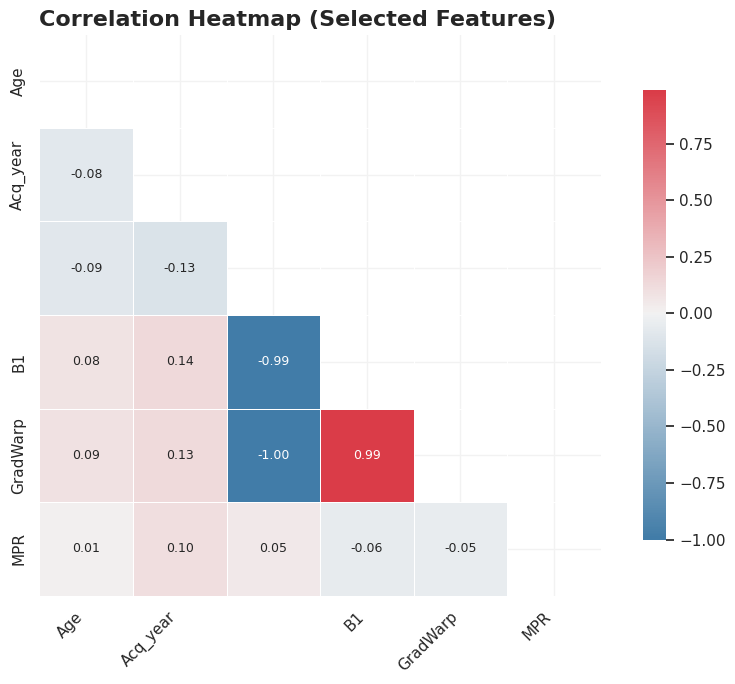

In [30]:
# ----------------------------
# 5) Correlation Heatmap (all numeric, constant cols removed)
# ----------------------------
def plot_corr_heatmap(df_num, title="Correlation Heatmap"):
    # Drop constant columns
    df_num = df_num.loc[:, df_num.nunique() > 1]
    corr = df_num.corr(numeric_only=True)

    # Mask upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(
        corr, mask=mask, cmap=sns.diverging_palette(240, 10, as_cmap=True),
        center=0, annot=True, fmt=".2f", linewidths=0.5, linecolor="white",
        square=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 9}, ax=ax
    )
    ax.set_title(title, fontsize=16, weight="bold", loc="left")
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_horizontalalignment("right")
    plt.tight_layout()
    plt.show()

# a) Using all numeric columns (after de-duping subjects)
dfdr = dfc.drop_duplicates("Subject")
numeric_df_all = dfdr.select_dtypes(include=["number"])
plot_corr_heatmap(numeric_df_all, title="Correlation Heatmap (All Numeric Features)")

# b) Using a specific subset (as in your original code)
cols_to_drop = ['Acq_month', 'Acq_day', 'N3', 'Scaled', 'MPR-R']
numeric_df_subset = dfdr.drop(columns=[c for c in cols_to_drop if c in dfdr.columns], errors="ignore") \
                        .select_dtypes(include=["number"])
plot_corr_heatmap(numeric_df_subset, title="Correlation Heatmap (Selected Features)")


Everything has almost 0 correlation. B1 Correction and GradWarp seem to be connected because they both correct image intensities caused by the MRI machine. We get NA values for N3 and Scaled because the values don't vary. If $x_i - \bar{x} = 0 \ ∀ \ x ∈ X$ then $𝜌 = \text{undefined}$. In this case, all x values are 1.

$$
𝜌_{xy} = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum(x_i - \bar{x})^2 \sum(y_i - \bar{y})^2}}
$$


In [ ]:
# clean with duplicates
dfc.to_parquet(os.path.join(base_path, baseline_path, 'ADNI1_Baseline_3T_2_25_2023_clean_wd.parquet'))
# clean with out duplicates
dfdr.to_parquet(os.path.join(base_path, baseline_path, 'ADNI1_Baseline_3T_2_25_2023_clean_wod.parquet'))